Import libraries and packages

In [2]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score

Define models

In [3]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

Reading data about *.txt

In [3]:
import pandas as pd

data_frame = pd.read_csv('features_ecb_1800_csv/features_txt_ecb.csv')
data_frame

,file_name,format,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,histogram_10,histogram_11,histogram_12,histogram_13,histogram_14,histogram_15,histogram_16,histogram_17,histogram_18,histogram_19,histogram_20,histogram_21,histogram_22,histogram_23,histogram_24,histogram_25,histogram_26,histogram_27,histogram_28,histogram_29,...,histogram_217,histogram_218,histogram_219,histogram_220,histogram_221,histogram_222,histogram_223,histogram_224,histogram_225,histogram_226,histogram_227,histogram_228,histogram_229,histogram_230,histogram_231,histogram_232,histogram_233,histogram_234,histogram_235,histogram_236,histogram_237,histogram_238,histogram_239,histogram_240,histogram_241,histogram_242,histogram_243,histogram_244,histogram_245,histogram_246,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0172.txt.enc,txt_ecb,7.982832,127.696644,5496.666581,74.139508,-0.009113,-1.198319,969484,10.212269,43,36,43,33,43,44,48,29,27,42,33,29,37,33,37,42,33,40,48,33,37,32,39,36,37,45,29,35,28,36,...,35,37,41,39,37,29,43,43,33,35,34,40,29,36,35,37,33,46,44,32,27,42,39,34,41,42,42,34,29,31,28,37,34,29,41,35,39,46,42,AES
1,file0101.txt.enc,txt_ecb,7.975912,126.806209,5514.940426,74.262645,0.006343,-1.226069,785201,10.362686,22,37,30,23,30,31,22,22,37,29,31,24,33,38,36,29,22,32,21,23,35,32,35,24,39,30,33,27,22,31,...,27,25,28,32,29,30,31,33,32,20,29,24,23,31,28,22,37,14,30,26,24,27,24,24,32,23,33,32,26,25,38,24,23,31,24,30,32,23,33,AES
2,file0256.txt.enc,txt_ecb,7.981360,126.981312,5414.598073,73.583953,0.002473,-1.193452,1019724,10.289235,41,33,36,32,34,39,39,38,33,43,39,35,38,32,47,49,34,28,39,47,45,47,35,39,44,47,31,31,49,27,...,35,39,36,33,36,45,35,48,33,31,49,44,41,35,30,39,42,40,28,38,36,31,37,27,43,39,26,29,42,38,31,39,32,43,48,43,33,37,23,AES
3,file0283.txt.enc,txt_ecb,7.982890,127.838430,5447.515631,73.807287,0.000281,-1.192133,1012524,10.227394,35,39,39,38,41,40,46,33,26,39,32,34,37,41,34,41,35,39,35,43,51,29,38,42,25,33,47,46,26,41,...,37,47,40,35,38,34,42,45,40,35,35,33,35,26,43,36,45,35,31,39,50,34,49,36,37,33,31,43,47,48,46,42,37,26,46,38,37,40,29,AES
4,file0038.txt.enc,txt_ecb,7.972436,126.735112,5511.100740,74.236788,0.023546,-1.211505,684582,10.303867,23,21,28,24,28,37,25,32,21,22,38,25,22,30,25,25,28,24,17,28,21,19,26,25,21,28,25,31,25,27,...,22,30,27,28,21,27,25,28,29,22,24,23,29,21,33,35,32,35,31,24,30,19,30,27,24,25,30,23,19,22,20,25,25,27,24,27,24,23,23,AES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,file0763.txt.enc,txt_ecb,7.894633,127.229567,5377.417251,73.330875,0.025364,-1.199614,177938,10.340885,0,4,7,9,6,9,9,5,8,3,9,5,4,1,5,6,4,6,10,9,6,7,8,7,7,6,8,5,7,5,...,4,6,8,8,8,5,12,7,8,10,8,6,4,3,9,5,6,5,5,7,10,8,11,5,11,10,6,3,6,9,7,2,5,3,9,3,5,7,6,DES3
1796,file1075.txt.enc,txt_ecb,7.938870,127.384302,5542.915684,74.450760,0.033947,-1.226293,348422,10.064068,19,12,8,11,13,13,10,8,12,9,18,17,8,13,12,20,10,18,10,12,13,14,11,12,14,8,15,15,9,16,...,11,19,11,16,20,14,14,17,10,11,6,25,14,11,13,13,19,13,14,9,18,12,13,16,11,16,20,13,14,11,18,9,18,15,14,11,17,16,14,DES3
1797,file0869.txt.enc,txt_ecb,7.952126,128.878653,5496.159336,74.136087,-0.014031,-1.219737,400945,10.228917,11,13,19,17,12,13,18,11,10,10,18,20,14,16,14,11,17,8,19,13,20,18,12,11,17,16,14,18,13,11,...,20,13,17,10,15,15,16,14,13,18,16,14,10,28,15,15,24,19,12,18,14,14,9,13,11,10,15,18,17,20,7,17,15,16,11,23,14,14,21,DES3
1798,file0898.txt.enc,txt_ecb,7.970693,127.074486,5475.251130,73.994940,0.010712,-1.209163,608181,10.204929,25,21,20,21,24,26,21,24,22,23,19,25,29,30,15,

Label encoding

In [4]:
encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


MinMaxScaler

In [6]:
X = data_frame.drop(columns=["algorithm", "file_name", "format"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Models training and testing with KFold cross validation

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")

/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

(<pandas.io.formats.style.Styler at 0x7f51c9b63a10>,
 <pandas.io.formats.style.Styler at 0x7f51c47df470>)

In [12]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.628333,0.031593,0.624654,0.033030,0.628333,0.031593,0.620859,0.034754,0.931832,0.864330
1,SVM,0.788889,0.021082,0.796320,0.020448,0.788889,0.021082,0.790660,0.021163,0.497254,0.954900
2,NaiveBayes,0.427222,0.029049,0.486631,0.102119,0.427222,0.029049,0.394723,0.040499,11.134366,0.739523
3,KNN,0.585556,0.020443,0.597612,0.020499,0.585556,0.020443,0.571000,0.021982,4.237340,0.825767
4,Bagging,0.606111,0.024305,0.603281,0.022342,0.606111,0.024305,0.599933,0.024245,0.909055,0.852916
5,AdaBoost,0.532778,0.030092,0.544594,0.029892,0.532778,0.030092,0.532804,0.029502,1.583318,0.767503


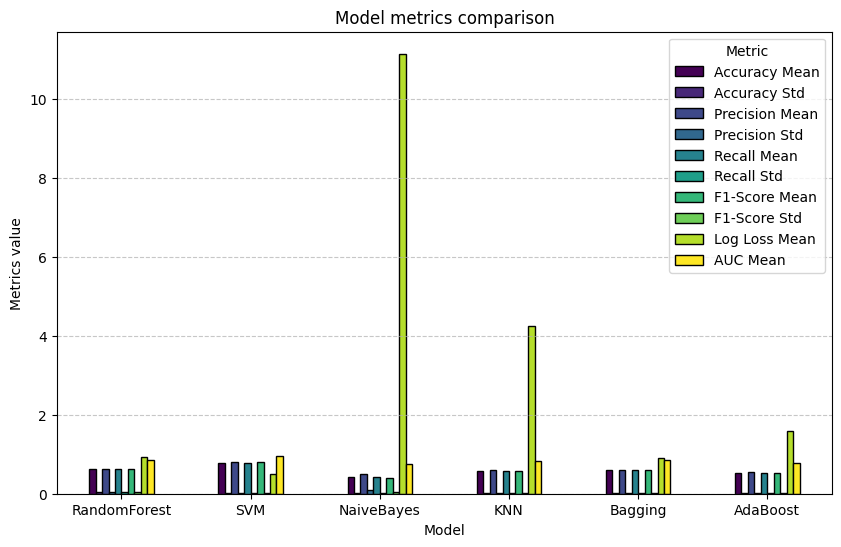

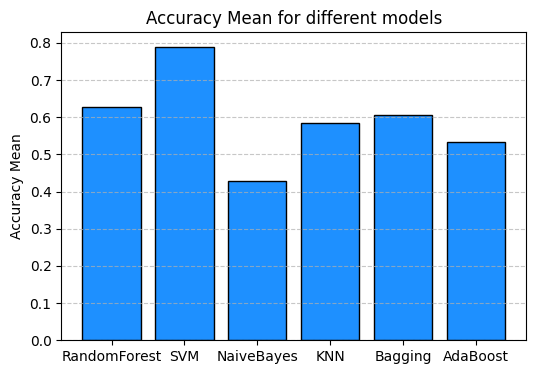

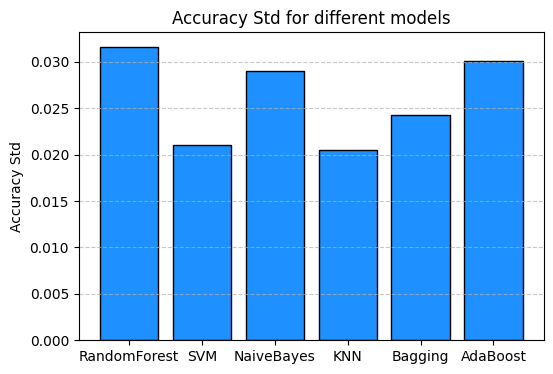

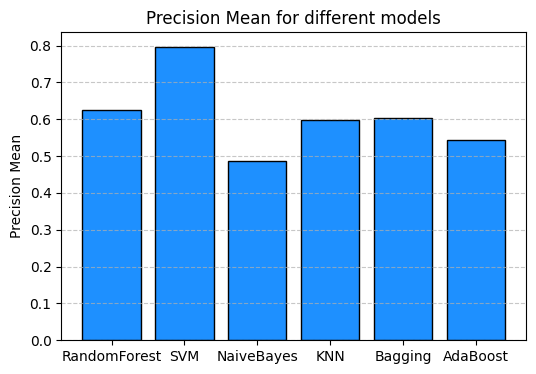

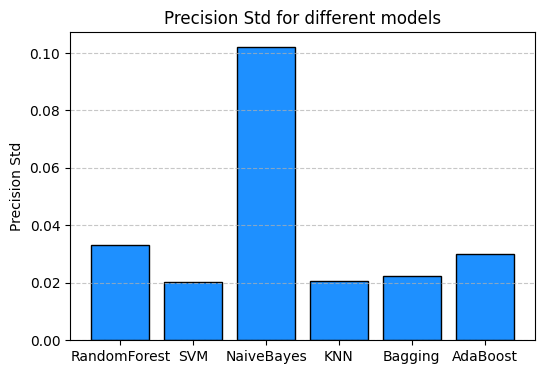

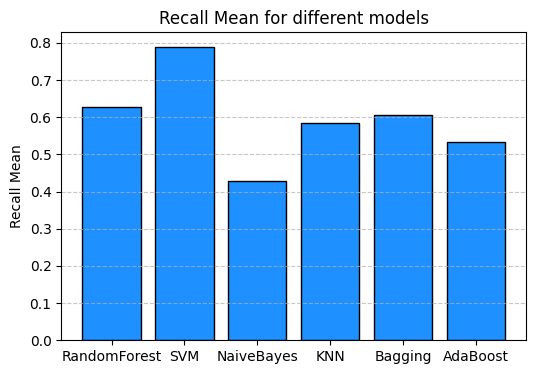

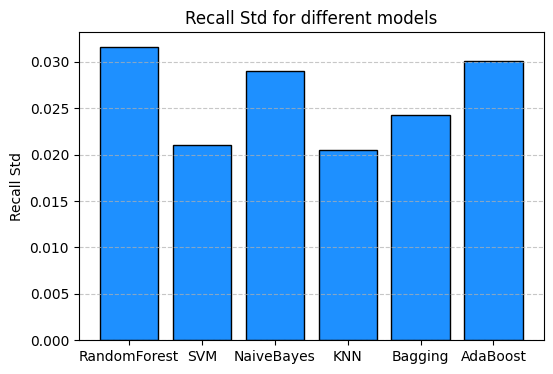

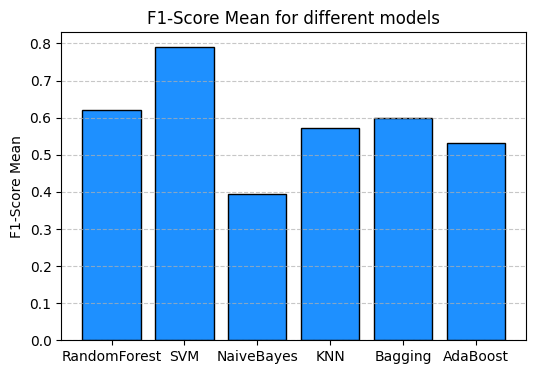

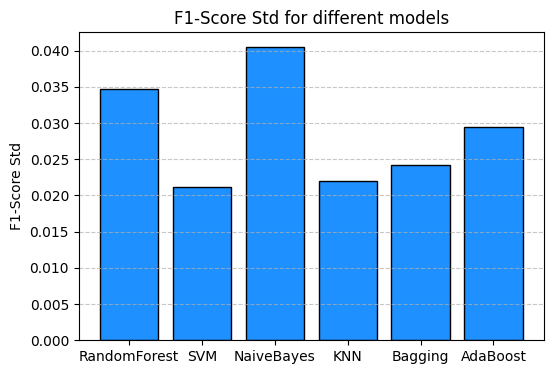

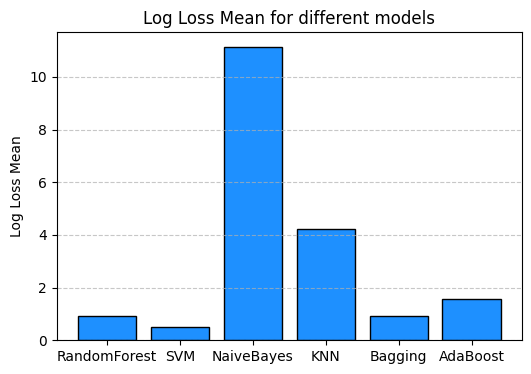

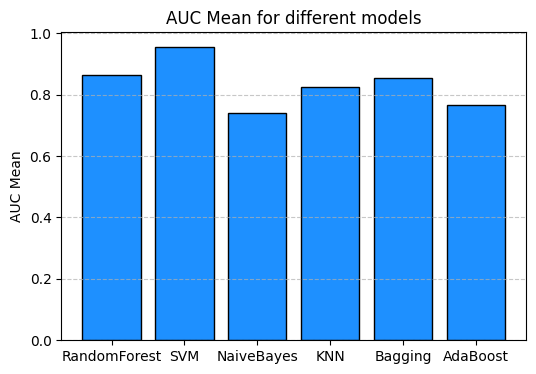

In [13]:
import matplotlib.pyplot as plt

df_results.set_index("Model").plot(kind="bar", figsize=(10,6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

Best model: SVM with F1-Score = 0.7888512671518477
Worst model: NaiveBayes with F1-Score = 0.39365140511048247


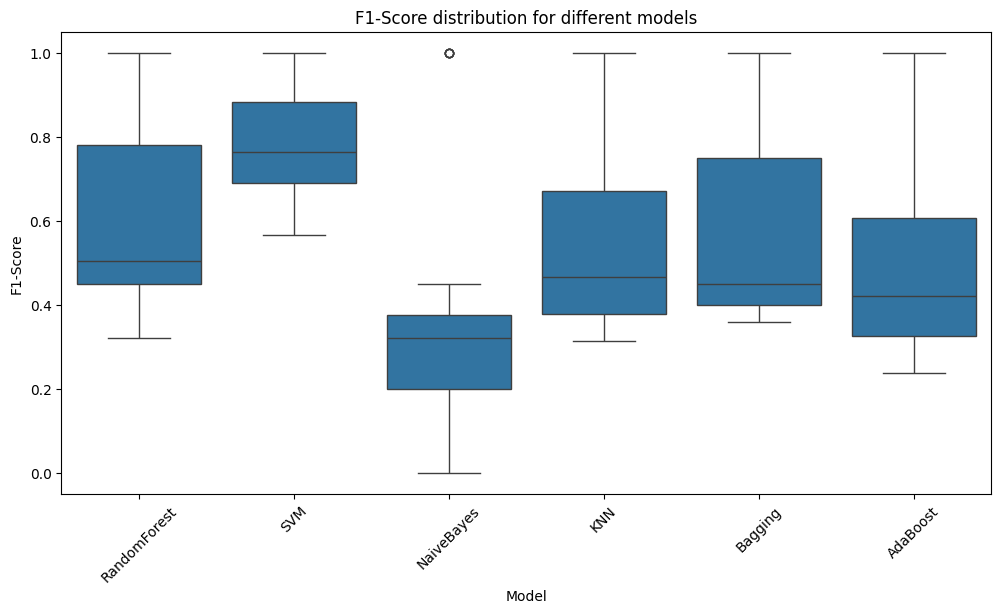

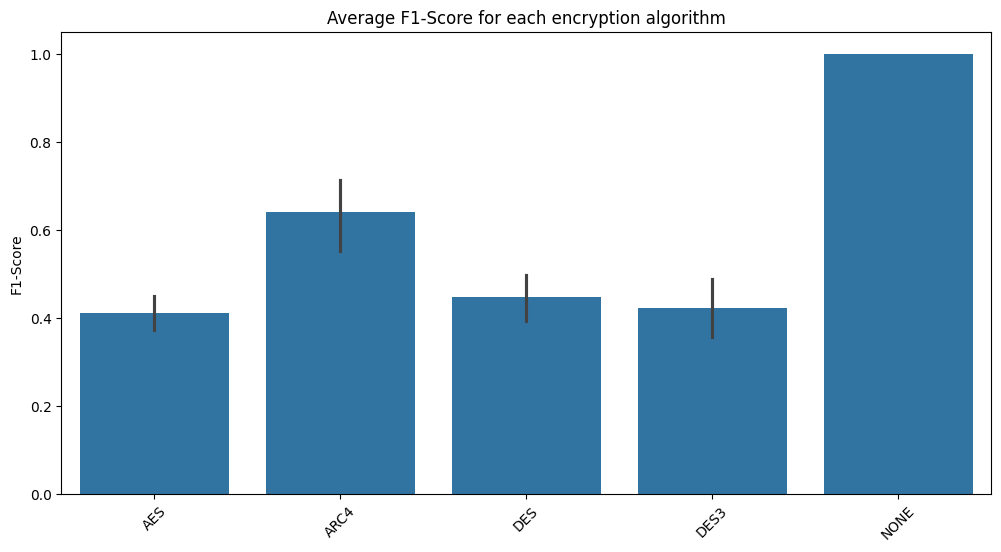

In [15]:
import seaborn as sns

model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()

In [16]:
df_class_results

,Model,Class,Precision,Recall,F1-Score
0,RandomForest,0,0.400000,0.405797,0.402878
1,RandomForest,1,0.750000,0.814815,0.781065
2,RandomForest,2,0.493671,0.565217,0.527027
3,RandomForest,3,0.542373,0.415584,0.470588
4,RandomForest,4,1.000000,1.000000,1.000000
...,...,...,...,...,...
145,AdaBoost,0,0.195876,0.301587,0.237500
146,AdaBoost,1,0.589041,0.632353,0.609929
147,AdaBoost,2,0.353846,0.302632,0.326241
148,AdaBoost,3,0.436364,0.289157,0.347826


Reading data about *.wav

In [2]:
import pandas as pd

data_frame = pd.read_csv('features_ecb_1800_csv/features_wav_ecb.csv')
data_frame

,file_name,format,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0332.wav.enc,wav_ecb,7.998862,127.565323,5480.404787,74.029756,-0.001148,-1.204133,37249497,10.274634,...,1364,1392,1472,1420,1342,1334,1360,1380,1344,AES
1,file0019.wav.enc,wav_ecb,7.998887,127.443527,5473.031399,73.979939,0.001695,-1.206081,27902312,10.267843,...,1015,977,977,979,1055,1023,1016,1084,993,AES
2,file0105.wav.enc,wav_ecb,7.998872,127.579337,5473.122817,73.980557,-0.001701,-1.202061,27935417,10.273932,...,1031,1054,1075,1040,993,1084,1036,1028,1039,AES
3,file0314.wav.enc,wav_ecb,7.998682,127.480345,5467.987198,73.945840,-0.001883,-1.202764,46508209,10.268759,...,1744,1742,1675,1587,1729,1852,1636,1850,1667,AES
4,file0192.wav.enc,wav_ecb,7.999205,127.090582,5465.281597,73.927543,0.005953,-1.202682,18624865,10.273968,...,655,674,693,659,702,634,659,710,680,AES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,file0856.wav.enc,wav_ecb,7.998112,127.435012,5448.663894,73.815065,0.001415,-1.195118,18593947,10.265437,...,700,684,664,666,729,698,592,703,718,DES3
1796,file0987.wav.enc,wav_ecb,7.998162,127.215571,5466.661386,73.936874,0.007280,-1.198964,46566533,10.275288,...,1781,1780,1645,1680,1670,1809,1730,1680,1810,DES3
1797,file1013.wav.enc,wav_ecb,7.997846,127.336394,5445.426170,73.793131,0.001604,-1.196714,37200878,10.267927,...,1469,1408,1236,1368,1236,1372,1232,1448,1256,DES3
1798,file1056.wav.enc,wav_ecb,7.997716,127.529810,5426.786505,73.666726,0.001985,-1.193991,18629114,10.275140,...,625,670,756,704,657,642,664,652,631,DES3


In [3]:
encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


In [4]:
X = data_frame.drop(columns=["algorithm", "file_name", "format"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")

/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

(<pandas.io.formats.style.Styler at 0x7f920e46ad50>,
 <pandas.io.formats.style.Styler at 0x7f92098dfd70>)

In [8]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.617222,0.020742,0.625223,0.028462,0.617222,0.020742,0.614835,0.024090,0.829513,0.893917
1,SVM,0.407778,0.030702,0.435164,0.073039,0.407778,0.030702,0.367269,0.034974,1.126475,0.692086
2,NaiveBayes,0.421667,0.025903,0.434758,0.104101,0.421667,0.025903,0.399043,0.030019,11.112570,0.732874
3,KNN,0.390000,0.034364,0.377875,0.037484,0.390000,0.034364,0.344372,0.038897,15.986972,0.636847
4,Bagging,0.617222,0.019035,0.621806,0.029849,0.617222,0.019035,0.614750,0.021849,0.689704,0.907411
5,AdaBoost,0.572778,0.033120,0.552937,0.051841,0.572778,0.033120,0.543995,0.054241,1.576057,0.875505


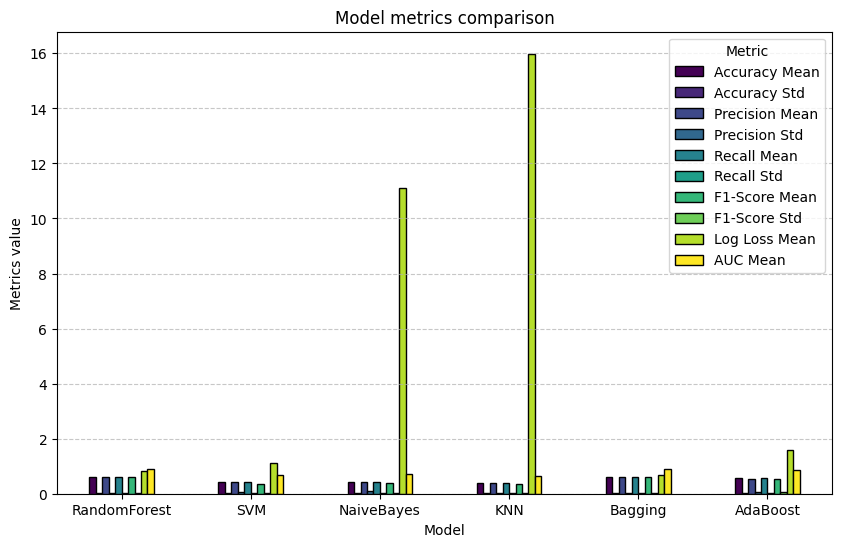

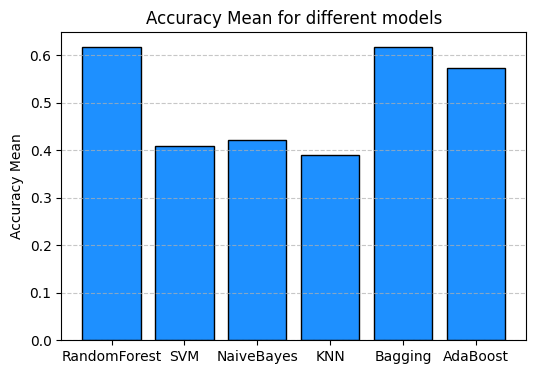

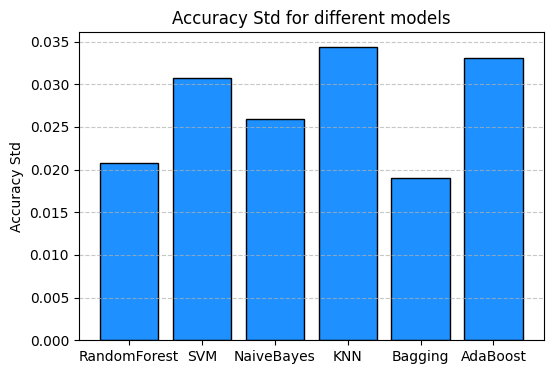

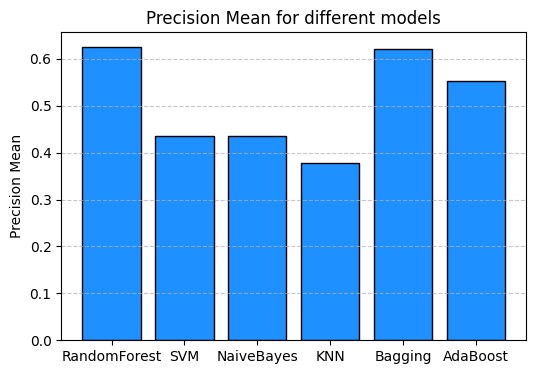

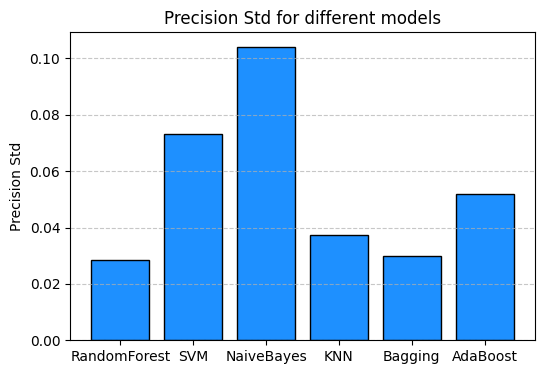

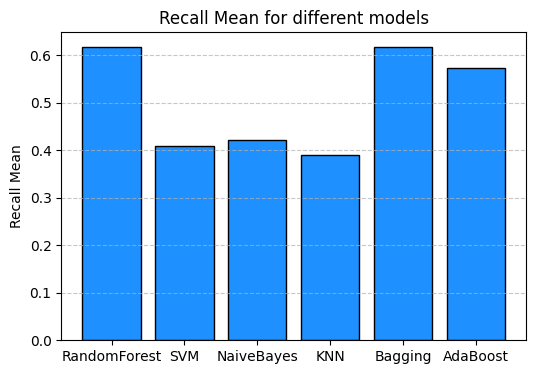

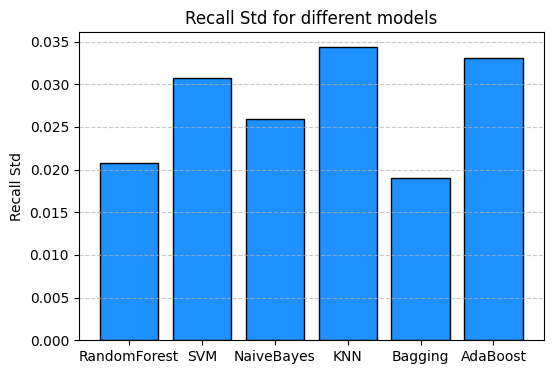

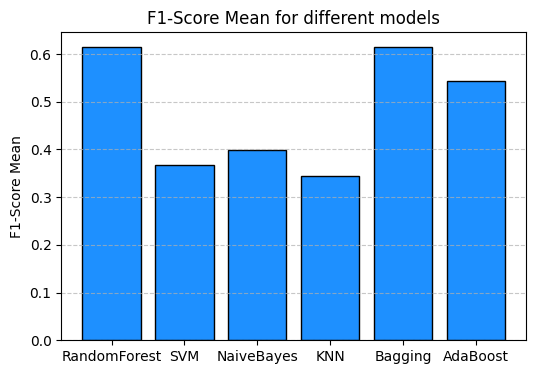

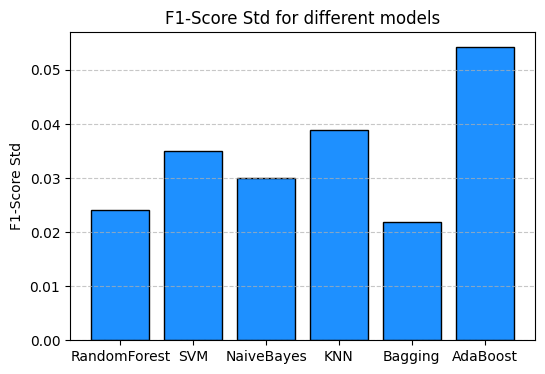

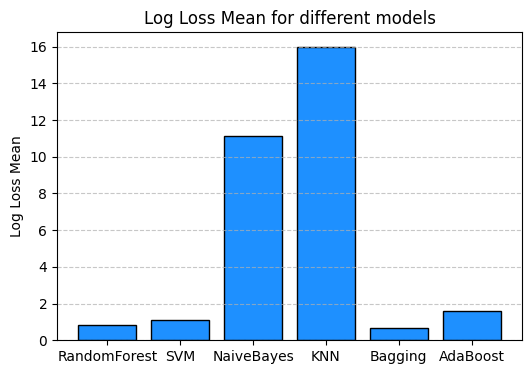

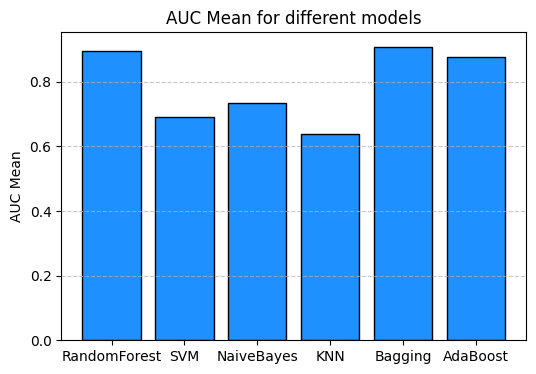

In [9]:
import matplotlib.pyplot as plt

df_results.set_index("Model").plot(kind="bar", figsize=(10,6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

*.csv

In [10]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

import pandas as pd

data_frame = pd.read_csv('features_ecb_1800_csv/features_csv_ecb.csv')
data_frame

,file_name,format,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0178.csv.enc,csv_ecb,5.894455,119.125000,5524.359375,74.326034,0.027929,-1.271522,6600,10.155048,...,1,0,0,0,0,0,0,1,0,AES
1,file0130.csv.enc,csv_ecb,6.222932,138.625000,6042.630208,77.734357,-0.173487,-1.212822,10066,10.239832,...,1,1,0,1,0,2,0,0,1,AES
2,file0294.csv.enc,csv_ecb,6.345083,134.544643,5592.069436,74.780141,-0.136844,-1.296513,12613,10.612072,...,2,0,0,1,0,0,0,1,0,AES
3,file0205.csv.enc,csv_ecb,6.560432,123.140625,6190.011475,78.676626,0.043954,-1.353155,12752,9.981232,...,0,1,0,0,0,0,1,2,1,AES
4,file0109.csv.enc,csv_ecb,5.875000,124.703125,4637.614990,68.100037,-0.065456,-1.009075,6175,9.822646,...,0,0,1,0,0,0,0,0,0,AES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,file0736.csv.enc,csv_ecb,6.165539,148.552083,4842.518121,69.588204,-0.369911,-0.862008,10583,10.499504,...,0,0,1,1,0,1,0,1,2,DES3
1796,file1048.csv.enc,csv_ecb,6.115515,123.363636,4787.095041,69.188836,0.139069,-1.176998,9972,10.645101,...,0,0,1,0,0,0,1,0,0,DES3
1797,file0947.csv.enc,csv_ecb,6.071928,129.550000,4689.447500,68.479541,-0.114103,-1.110550,7988,9.992497,...,0,0,2,0,0,0,0,0,0,DES3
1798,file0975.csv.enc,csv_ecb,5.628783,125.803571,5206.550702,72.156432,0.107029,-1.078945,5885,10.251307,...,0,0,0,0,0,0,0,0,2,DES3


In [11]:
encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)
X = data_frame.drop(columns=["algorithm", "file_name", "format"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


(<pandas.io.formats.style.Styler at 0x7f9208a061e0>,
 <pandas.io.formats.style.Styler at 0x7f920e46ce60>)

In [12]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.588333,0.024495,0.582474,0.029086,0.588333,0.024495,0.575879,0.026618,0.979502,0.840672
1,SVM,0.575000,0.034605,0.578317,0.033437,0.575000,0.034605,0.574074,0.034678,0.856077,0.847586
2,NaiveBayes,0.593333,0.024127,0.590504,0.022461,0.593333,0.024127,0.588554,0.024639,2.590588,0.848292
3,KNN,0.496111,0.030103,0.545774,0.032653,0.496111,0.030103,0.453236,0.030876,7.763698,0.769799
4,Bagging,0.575000,0.026469,0.571151,0.021178,0.575000,0.026469,0.564636,0.027483,0.948940,0.833218
5,AdaBoost,0.508889,0.019357,0.528197,0.029385,0.508889,0.019357,0.509352,0.021451,1.582696,0.787134


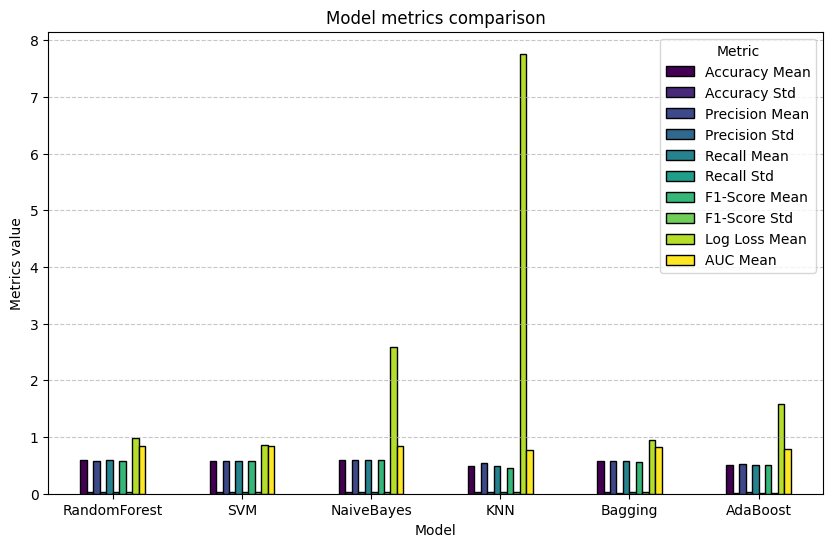

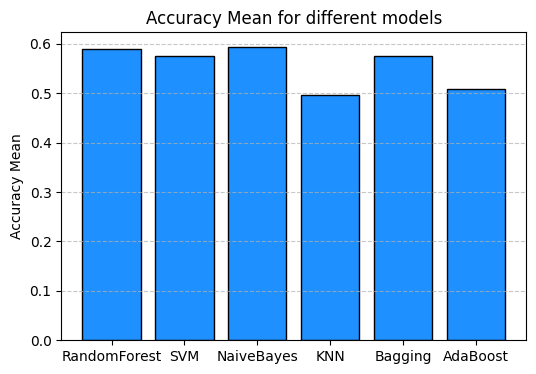

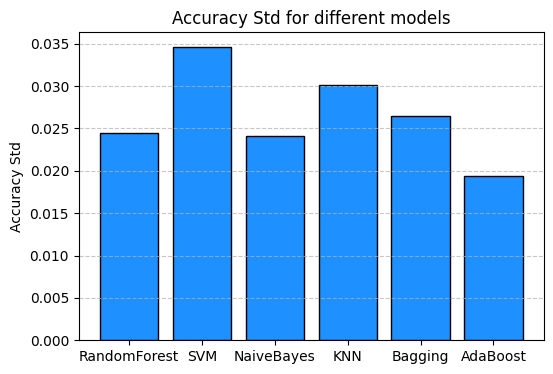

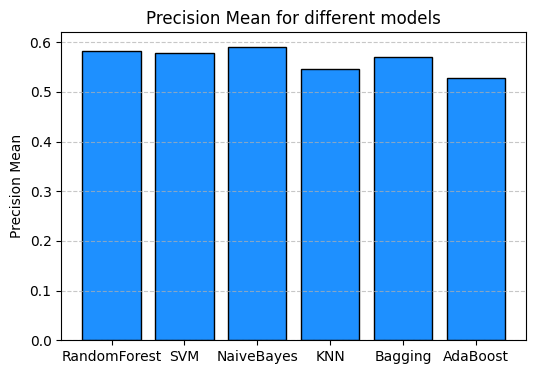

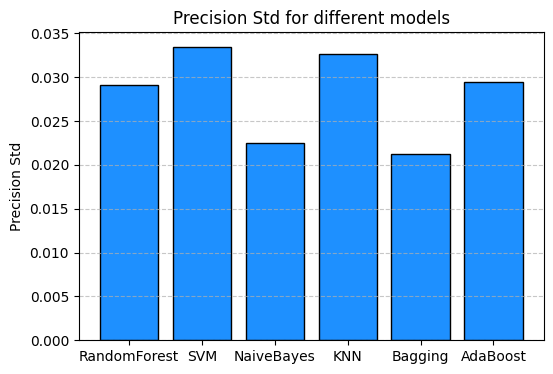

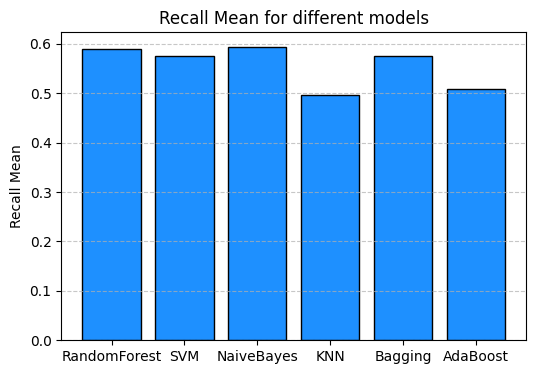

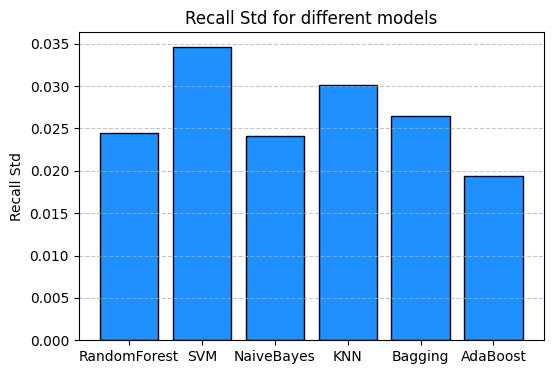

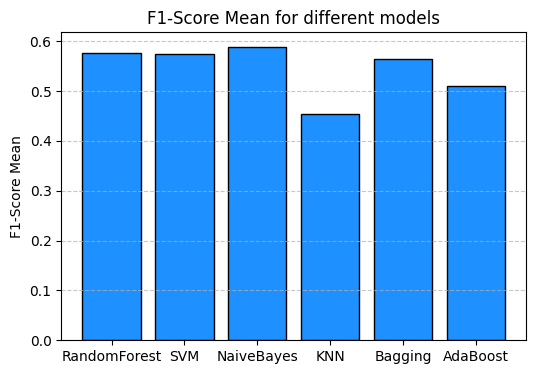

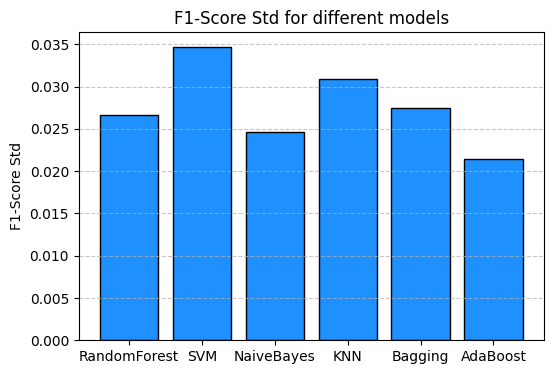

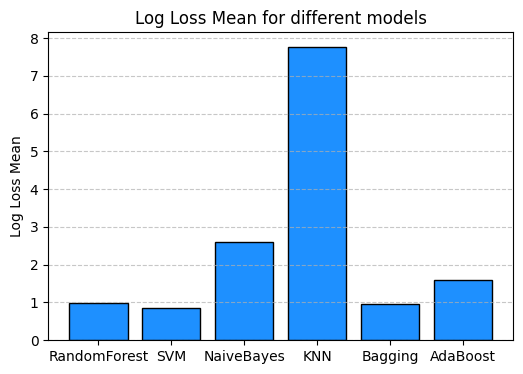

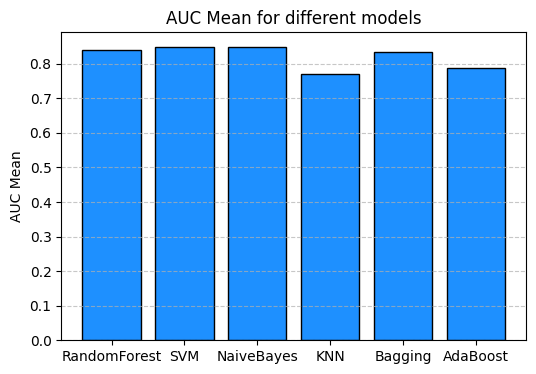

In [13]:
import matplotlib.pyplot as plt

df_results.set_index("Model").plot(kind="bar", figsize=(10,6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

All formats

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

import pandas as pd

data_frame = pd.read_csv('features_ecb_1800_csv/features_all.csv')
data_frame

,file_name,format,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0191.py.enc,pyth_ecb,7.980526,125.381195,5517.303142,74.278551,0.035799,-1.210287,953842,10.271976,...,39,40,34,35,33,44,23,34,31,AES
1,file0173.py.enc,pyth_ecb,7.900088,125.606250,5479.996403,74.026998,0.034334,-1.206150,221831,10.327125,...,10,10,11,9,7,3,10,9,8,AES
2,file0221.py.enc,pyth_ecb,7.977533,127.083289,5474.737066,73.991466,-0.004145,-1.199067,790237,10.262006,...,29,35,26,27,28,29,25,36,30,AES
3,file0296.py.enc,pyth_ecb,7.848085,128.158594,5673.845942,75.324936,-0.023980,-1.246576,131675,10.142539,...,8,5,4,4,3,6,6,8,4,AES
4,file0306.py.enc,pyth_ecb,7.455981,128.047500,5314.405244,72.899967,-0.053905,-1.163603,41155,10.143348,...,1,2,3,2,0,1,2,3,1,AES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,image_0925.bmp.enc,bmp_ecb,4.511462,125.262556,4649.398731,68.186500,0.198453,-1.056225,7808101,10.079380,...,0,0,0,1,0,0,0,3200,2,DES3
10796,image_1068.bmp.enc,bmp_ecb,4.676194,126.714632,5696.909540,75.477875,0.261747,-1.360077,7938214,10.017059,...,1,0,0,0,0,1,0,3240,0,DES3
10797,image_0781.bmp.enc,bmp_ecb,4.609259,142.882462,5434.801216,73.721104,0.002599,-1.525986,15209189,12.156348,...,0,0,0,0,92,0,1,0,4163,DES3
10798,image_0780.bmp.enc,bmp_ecb,4.567454,143.132240,5713.116060,75.585158,-0.432486,-1.127319,24044012,9.617382,...,0,0,0,0,0,0,1,2,10731,DES3


In [2]:
encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)
X = data_frame.drop(columns=["algorithm", "file_name", "format"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


(<pandas.io.formats.style.Styler at 0x7f250d203cb0>,
 <pandas.io.formats.style.Styler at 0x7f250d248bc0>)

In [3]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.777315,0.007949,0.782075,0.007313,0.777315,0.007949,0.774751,0.008427,0.662902,0.950691
1,SVM,0.404537,0.003944,0.428321,0.012456,0.404537,0.003944,0.357354,0.008525,1.218823,0.733638
2,NaiveBayes,0.269444,0.006328,0.272921,0.013655,0.269444,0.006328,0.211542,0.007042,25.337561,0.587285
3,KNN,0.563426,0.011631,0.577008,0.011614,0.563426,0.011631,0.556993,0.013165,6.453344,0.801197
4,Bagging,0.750648,0.007800,0.755043,0.006712,0.750648,0.007800,0.748569,0.008317,0.588295,0.946489
5,AdaBoost,0.457222,0.026877,0.553394,0.045012,0.457222,0.026877,0.406566,0.043491,1.585132,0.767990


In [1]:
import matplotlib.pyplot as plt

df_results.set_index("Model").plot(kind="bar", figsize=(10,6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

NameError: name 'df_results' is not defined

1800 files with 3 keys

In [4]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

In [7]:
import pandas as pd

data_frame_1800_3_txt = pd.read_csv('features_ecb_1800_3keys_csv/features_txt_ecb.csv')
data_frame_1800_3_txt

,file_name,format,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0172.txt.enc,txt_ecb,7.977890,127.324441,5407.540392,73.535980,-0.003702,-1.200612,971746,10.224176,...,34,33,34,31,29,30,45,30,31,AES
1,file0101.txt.enc,txt_ecb,7.973978,127.035832,5466.134110,73.933309,-0.004053,-1.210962,777986,10.314966,...,23,18,35,36,23,31,31,28,18,AES
2,file0256.txt.enc,txt_ecb,7.981881,126.916840,5481.322092,74.035951,0.028979,-1.207570,1016547,10.273194,...,32,30,41,41,44,47,35,39,34,AES
3,file0283.txt.enc,txt_ecb,7.980998,126.327376,5483.993341,74.053989,0.030307,-1.212038,1014857,10.239170,...,38,39,34,39,39,35,40,26,47,AES
4,file0038.txt.enc,txt_ecb,7.975465,127.702388,5566.910652,74.611733,0.000236,-1.242079,684235,10.301255,...,35,21,18,23,28,26,21,15,32,AES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,file0763.txt.enc,txt_ecb,7.897925,127.462740,5487.663275,74.078764,-0.012305,-1.191923,171184,10.142731,...,4,13,8,9,5,6,4,4,7,DES3
1796,file1075.txt.enc,txt_ecb,7.950127,126.399419,5525.344535,74.332661,0.031259,-1.213616,359998,10.229887,...,16,11,12,13,13,14,15,16,13,DES3
1797,file0869.txt.enc,txt_ecb,7.954132,128.240605,5558.761524,74.557102,-0.035356,-1.201563,403604,10.262779,...,13,11,16,13,14,15,16,17,17,DES3
1798,file0898.txt.enc,txt_ecb,7.969943,128.345377,5462.061708,73.905762,-0.019477,-1.208768,625665,10.350576,...,21,21,19,14,28,23,25,16,22,DES3


In [8]:
encoder = LabelEncoder()
data_frame_1800_3_txt['algorithm'] = encoder.fit_transform(data_frame_1800_3_txt['algorithm'])
print(encoder.classes_)
X = data_frame_1800_3_txt.drop(columns=["algorithm", "file_name", "format"])
y = data_frame_1800_3_txt["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []

    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")
df_results

/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kevvol/projects/praca_magisterska/pythonProject/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.514444,0.026897,0.513872,0.029311,0.514444,0.026897,0.510113,0.028366,1.051912,0.787814
1,SVM,0.616111,0.036150,0.623608,0.035475,0.616111,0.036150,0.615494,0.037999,0.835592,0.874822
2,NaiveBayes,0.403889,0.021844,0.356018,0.036994,0.403889,0.021844,0.361126,0.027859,11.513256,0.715170
3,KNN,0.473889,0.021344,0.476460,0.018248,0.473889,0.021344,0.464799,0.021320,5.524010,0.744512
4,Bagging,0.523889,0.017708,0.520768,0.017317,0.523889,0.017708,0.517981,0.017767,1.010119,0.800489
5,AdaBoost,0.460556,0.018791,0.478455,0.023240,0.460556,0.018791,0.454917,0.018387,1.584754,0.760638


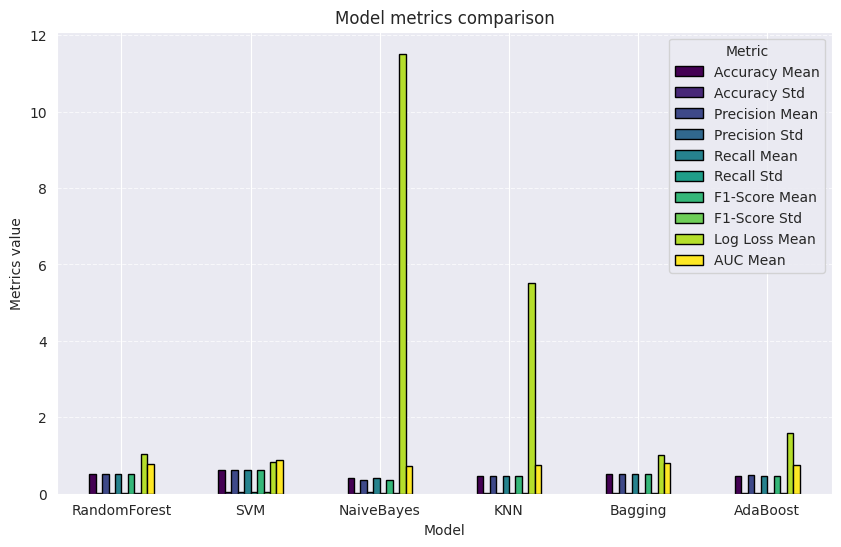

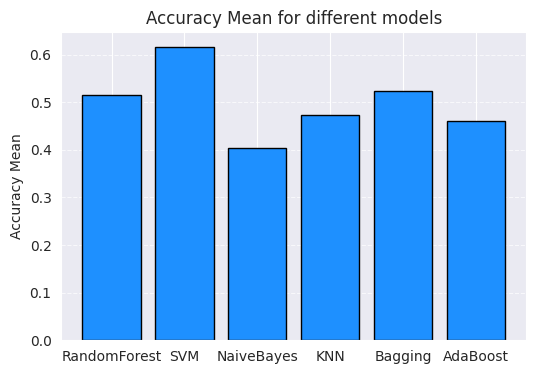

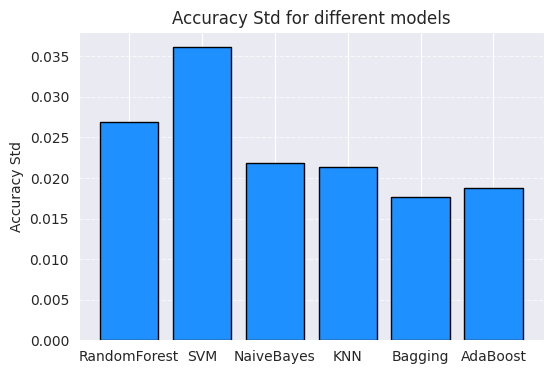

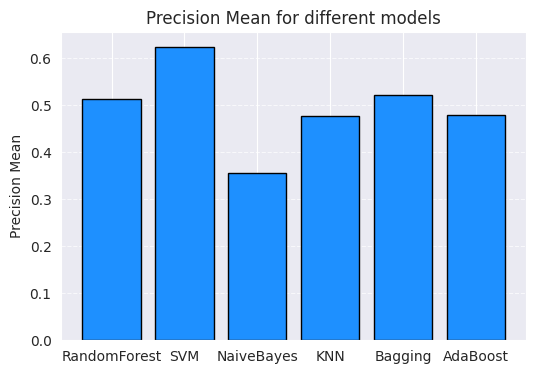

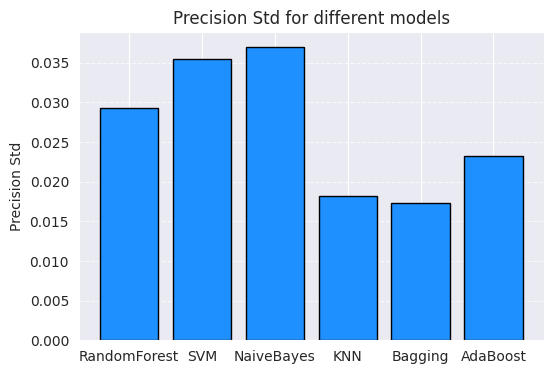

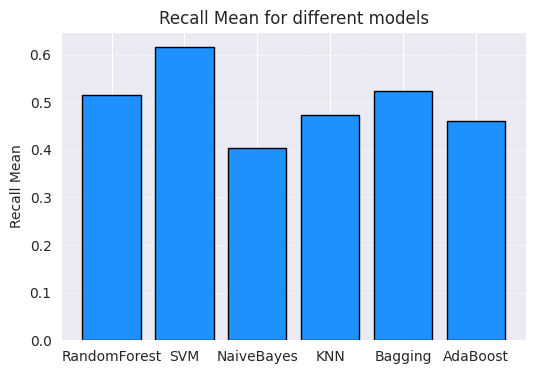

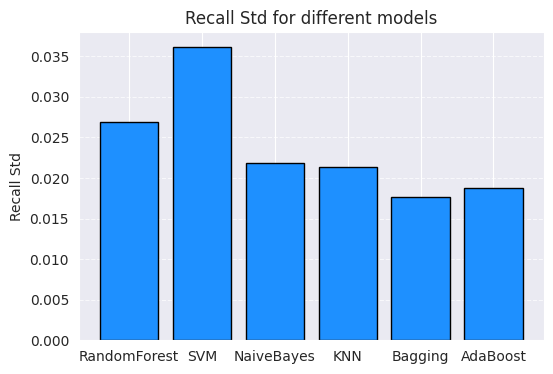

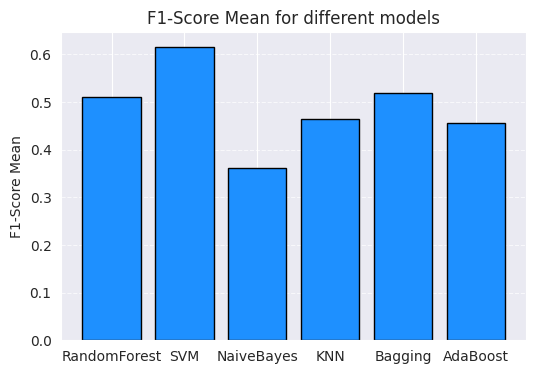

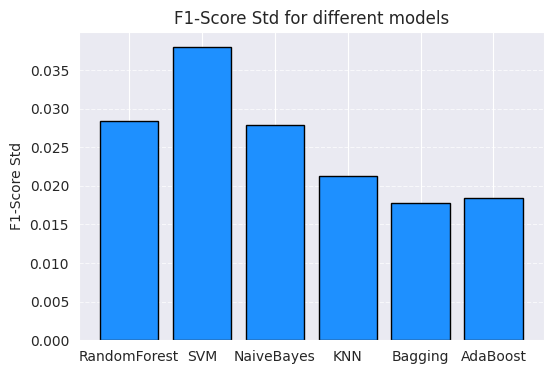

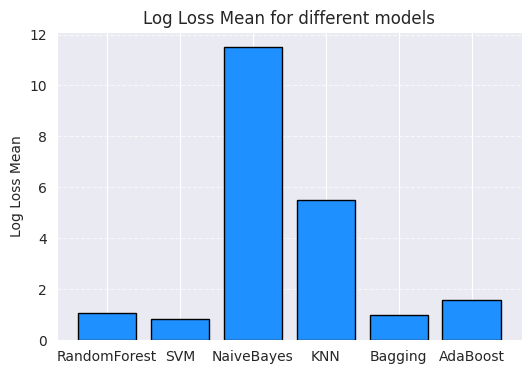

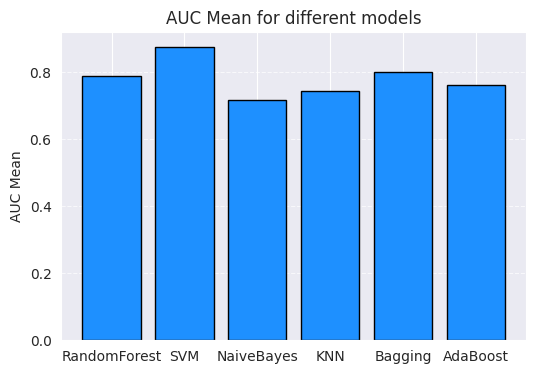

Best model: SVM with F1-Score = 0.6154178161658979
Worst model: NaiveBayes with F1-Score = 0.3604521816086717


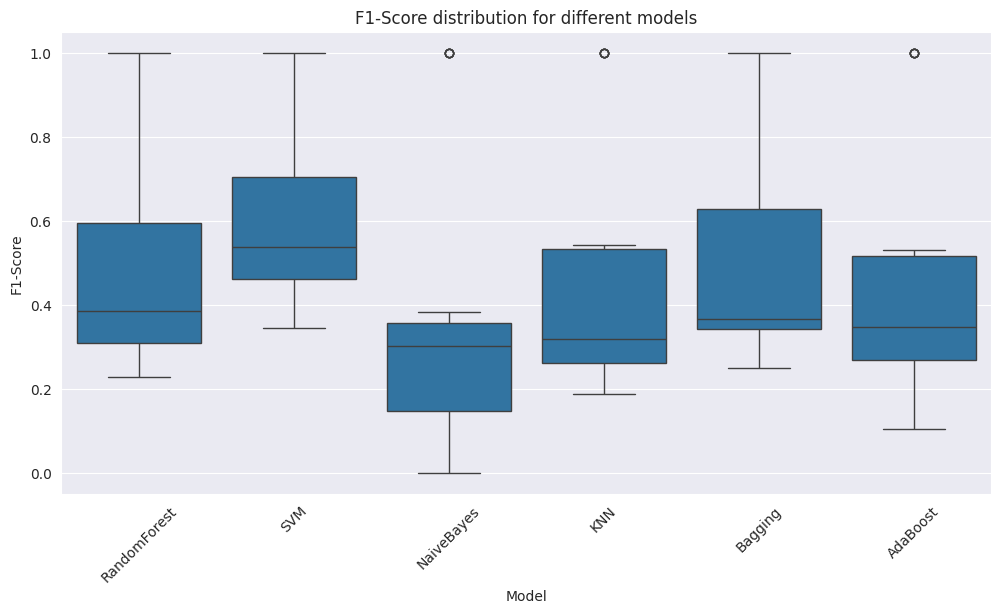

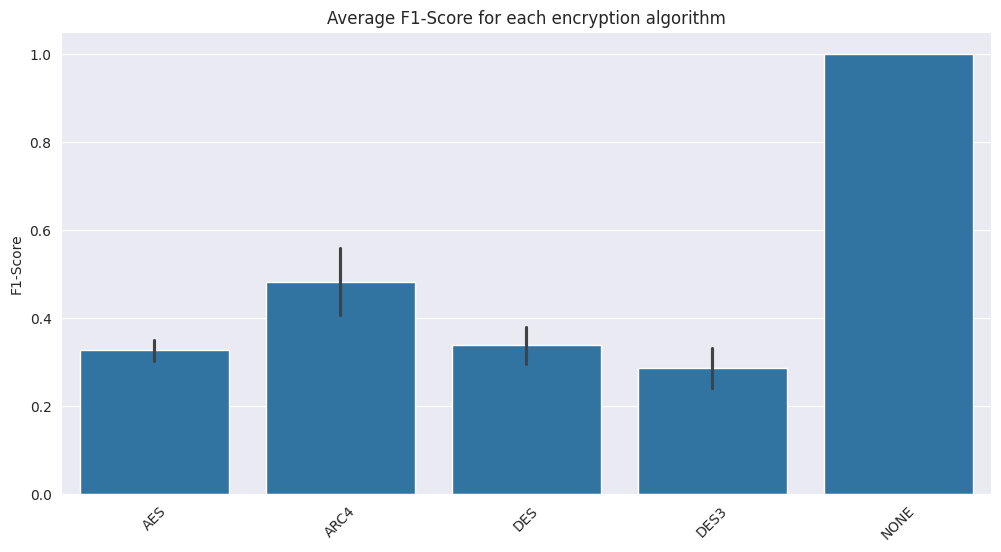

In [10]:
import matplotlib.pyplot as plt

df_results.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6, 4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
import seaborn as sns

model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12, 6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()


1800 txts with 3 keys in ebc different alghoritms

In [13]:
data_frame_1800_3_all = pd.read_csv('features_ecb_1800_3keys_csv/features_all.csv')

encoder = LabelEncoder()
data_frame_1800_3_all['algorithm'] = encoder.fit_transform(data_frame_1800_3_all['algorithm'])
print(encoder.classes_)
X = data_frame_1800_3_all.drop(columns=["algorithm", "file_name", "format"])
y = data_frame_1800_3_all["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []

    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")
df_results

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.725093,0.013262,0.732860,0.012417,0.725093,0.013262,0.723358,0.012687,0.771407,0.923790
1,SVM,0.399907,0.005881,0.413564,0.018651,0.399907,0.005881,0.347818,0.014414,1.218024,0.727096
2,NaiveBayes,0.268796,0.006005,0.271741,0.016579,0.268796,0.006005,0.210932,0.004258,25.393725,0.583179
3,KNN,0.521019,0.009391,0.542074,0.010431,0.521019,0.009391,0.516118,0.010754,7.010532,0.774795
4,Bagging,0.715093,0.010946,0.722065,0.013199,0.715093,0.010946,0.713882,0.011244,0.694182,0.925918
5,AdaBoost,0.445463,0.007749,0.579300,0.077246,0.445463,0.007749,0.391953,0.013647,1.585238,0.766287


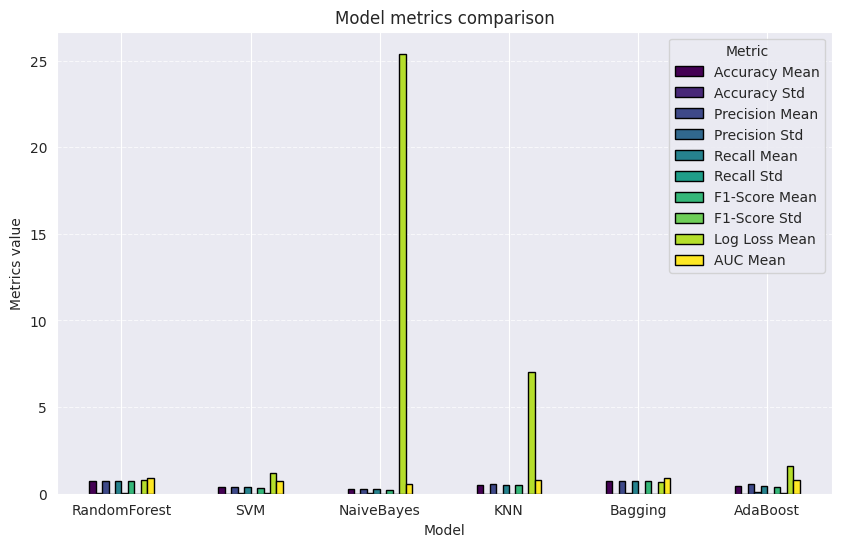

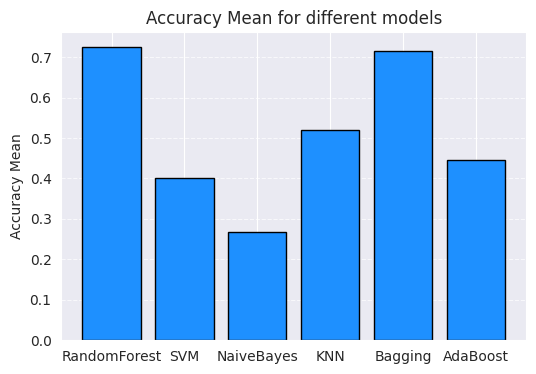

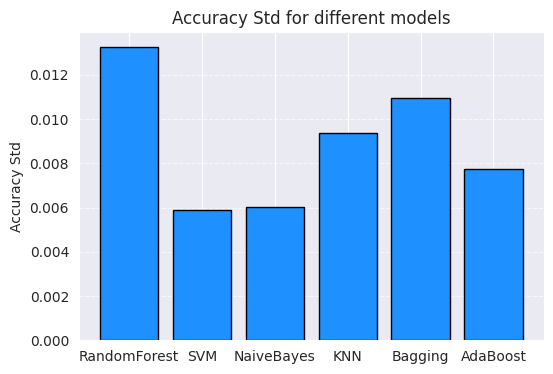

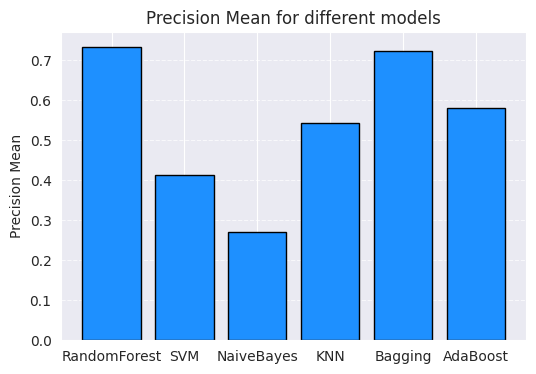

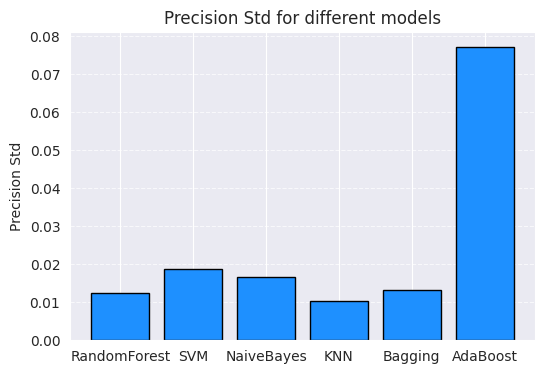

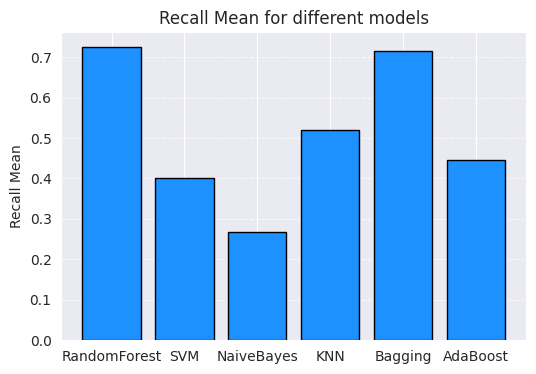

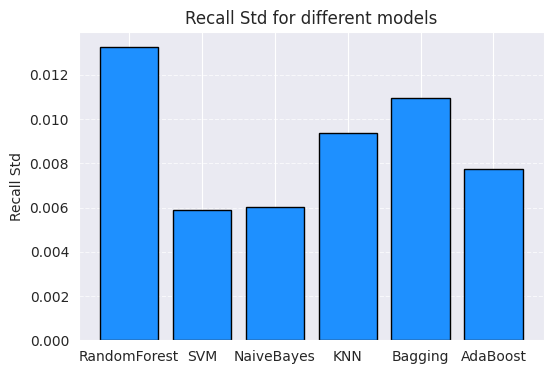

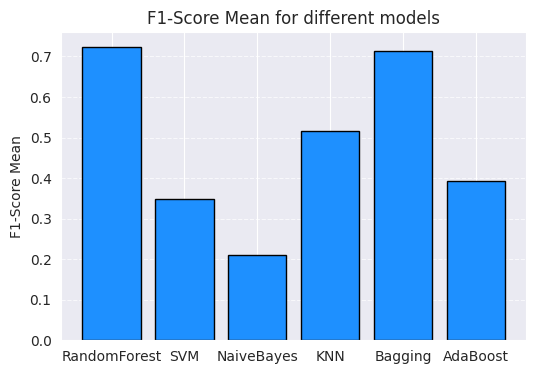

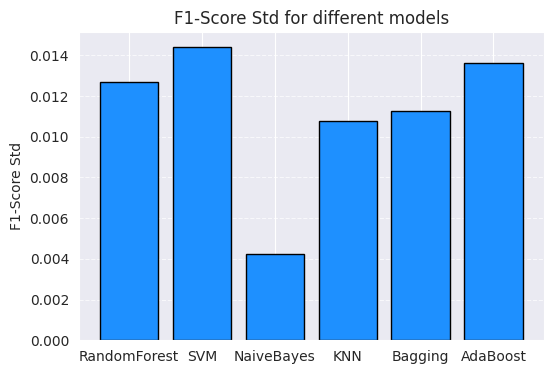

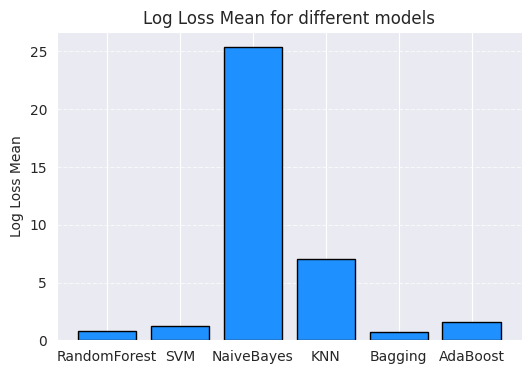

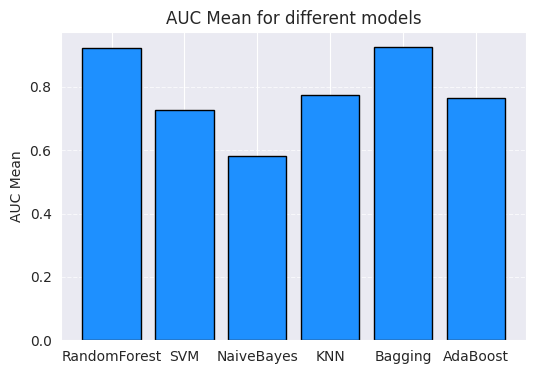

Best model: RandomForest with F1-Score = 0.7234300650694598
Worst model: NaiveBayes with F1-Score = 0.2112356782263366


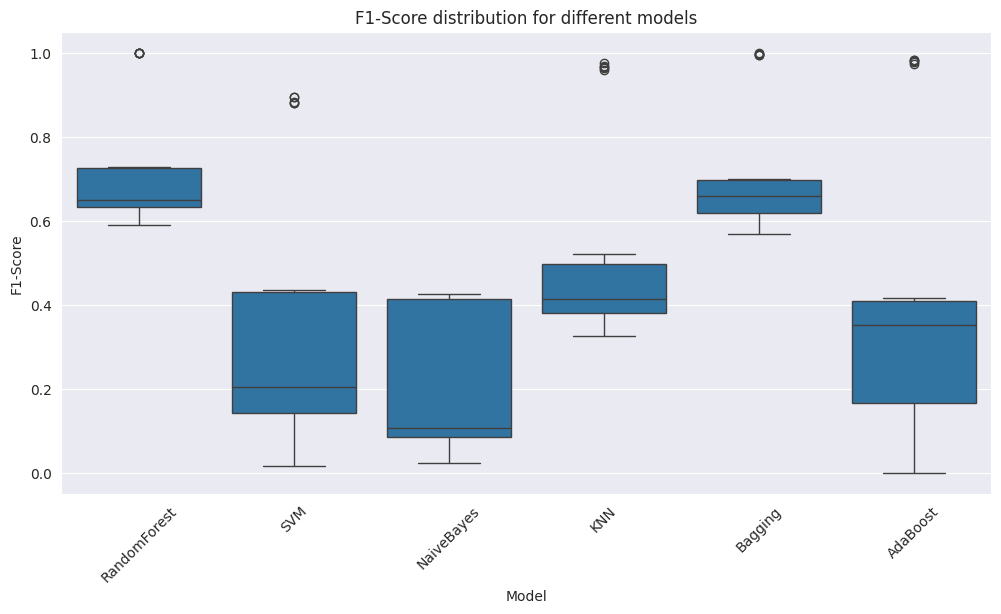

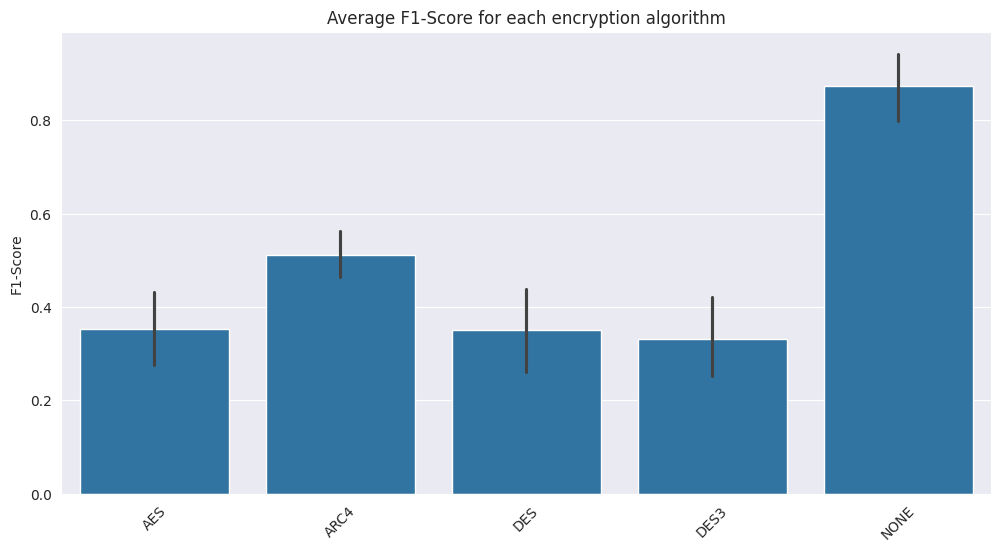

In [14]:
import matplotlib.pyplot as plt

df_results.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6, 4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
import seaborn as sns

model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12, 6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()


In [15]:
data_frame_1800_6_all = pd.read_csv('features_ecb_1800_6keys_csv/features_all.csv')

encoder = LabelEncoder()
data_frame_1800_6_all['algorithm'] = encoder.fit_transform(data_frame_1800_6_all['algorithm'])
print(encoder.classes_)
X = data_frame_1800_6_all.drop(columns=["algorithm", "file_name", "format"])
y = data_frame_1800_6_all["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []

    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")
df_results

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.684167,0.015745,0.692112,0.015015,0.684167,0.015745,0.684446,0.016276,0.832483,0.901387
1,SVM,0.401019,0.005142,0.417581,0.017607,0.401019,0.005142,0.349021,0.009853,1.225138,0.727770
2,NaiveBayes,0.269444,0.004479,0.264832,0.014500,0.269444,0.004479,0.211250,0.005128,25.374676,0.581630
3,KNN,0.497130,0.005512,0.514805,0.006882,0.497130,0.005512,0.492664,0.006545,7.263973,0.760969
4,Bagging,0.679444,0.008679,0.687674,0.008063,0.679444,0.008679,0.680062,0.008681,0.752066,0.908625
5,AdaBoost,0.454815,0.010592,0.600960,0.028089,0.454815,0.010592,0.403634,0.013383,1.585166,0.758478


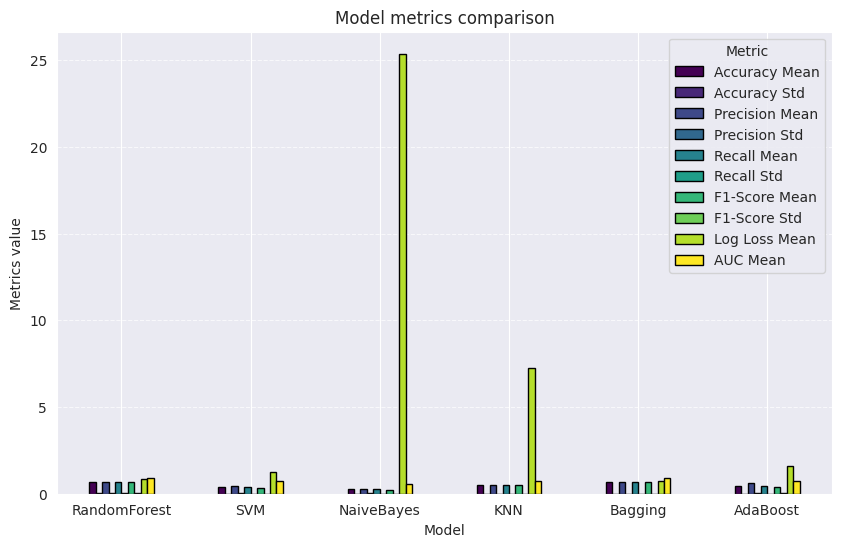

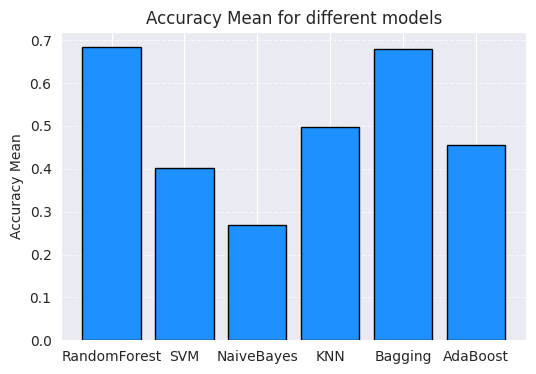

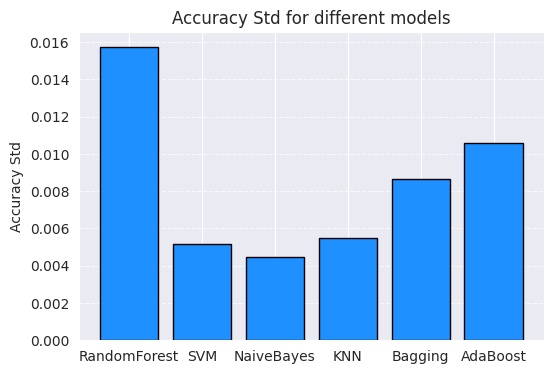

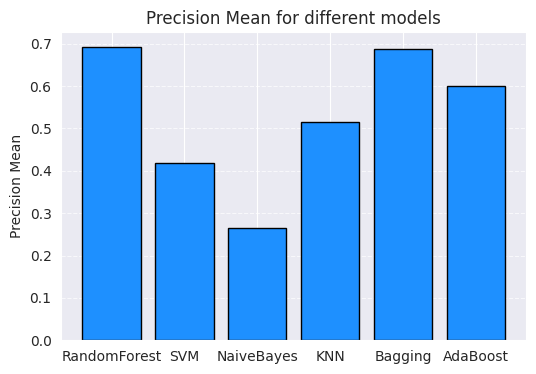

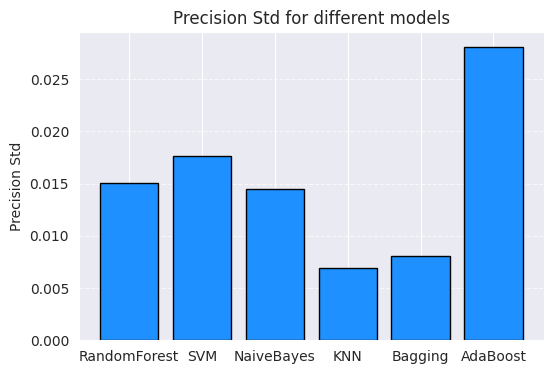

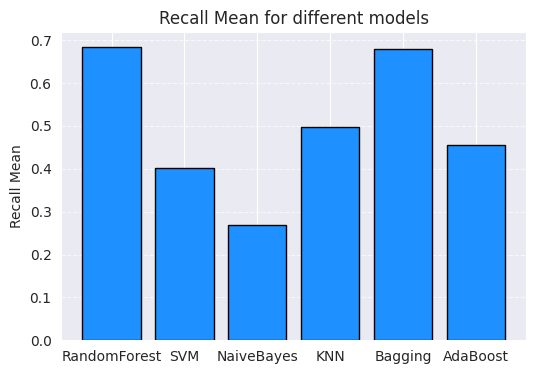

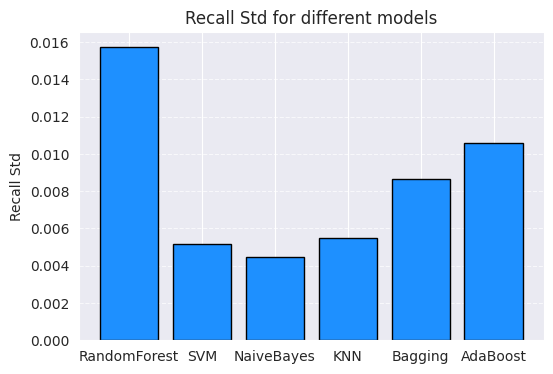

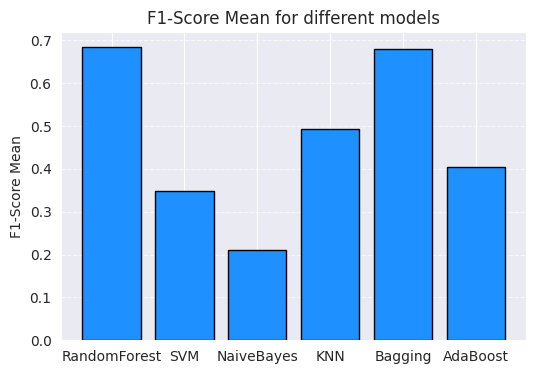

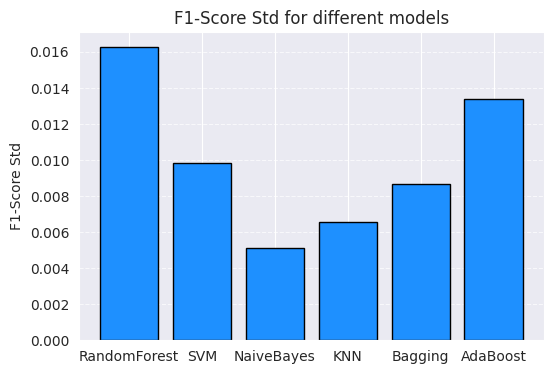

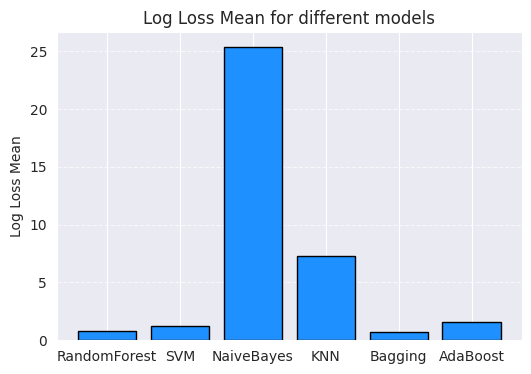

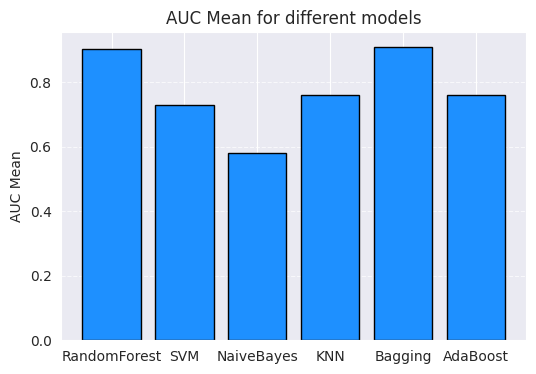

Best model: RandomForest with F1-Score = 0.6843905118138254
Worst model: NaiveBayes with F1-Score = 0.2115479743519198


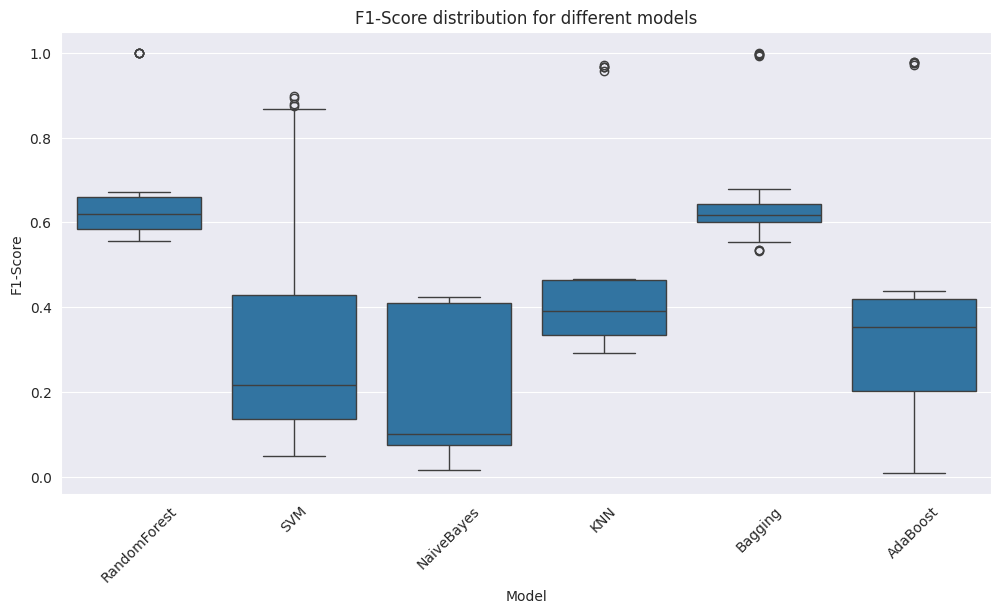

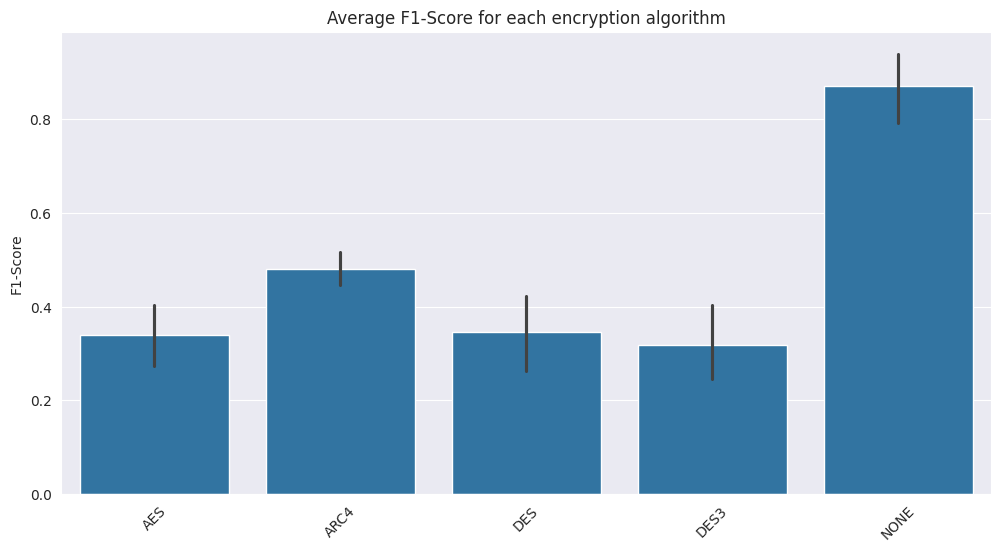

In [16]:
import matplotlib.pyplot as plt

df_results.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis", edgecolor="black")
plt.title("Model metrics comparison")
plt.ylabel("Metrics value")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6, 4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.title(f"{metric} for different models")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
import seaborn as sns

model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12, 6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()


In [4]:
data_frame_3000_all = pd.read_csv('features_ecb_3000_csv/features_all.csv')

encoder = LabelEncoder()
data_frame_3000_all['algorithm'] = encoder.fit_transform(data_frame_3000_all['algorithm'])
print(encoder.classes_)
X = data_frame_3000_all.drop(columns=["algorithm", "file_name", "format"])
y = data_frame_3000_all["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []

    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")
df_results

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.779000,0.003783,0.784943,0.004804,0.779000,0.003783,0.776754,0.003997,0.636027,0.953589
1,SVM,0.403667,0.005626,0.416555,0.009765,0.403667,0.005626,0.355304,0.006024,1.199893,0.730617
2,NaiveBayes,0.271278,0.009760,0.268995,0.024909,0.271278,0.009760,0.208802,0.010501,25.243866,0.578318
3,KNN,0.585389,0.003472,0.602246,0.002731,0.585389,0.003472,0.578406,0.003094,6.357461,0.811373
4,Bagging,0.766278,0.003704,0.770627,0.003794,0.766278,0.003704,0.764830,0.003676,0.564224,0.950041
5,AdaBoost,0.498000,0.020091,0.560167,0.045438,0.498000,0.020091,0.464461,0.030391,1.584134,0.792648
